In [1]:
# Author: Arthur Prigent
# Email: aprigent@ictp.it

In [2]:
from load_librairies import *
from scipy.stats.stats import pearsonr
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy
import matplotlib.transforms as transforms

def nandetrend(y):
    ''' Remove the linear trend from the data '''
    
    x = np.arange(0,y.shape[0],1)
    m, b, r_val, p_val, std_err = stats.linregress(x,np.array(y))
    y_detrended= np.array(y) - m*x
    return y_detrended

def is_jja(month):
    return (month>=6) & (month<=8)

def is_mjj(month):
    return (month>=5) & (month<=7)
def is_amj(month):
    return (month>=4) & (month<=6)

def is_mam(month):
    return (month>=3) & (month<=5)
def is_nd(month):
    return (month==11) | (month==12)


dir_proj = '/home/netapp-clima-users/users/aprigent/Projects/TAV_OMIP/'
path_fig = dir_proj+'/figures_final/'
path_data_out = '/media/aprigent/Arthur_disk/data_uncertainty/'
dir_oras5 = '/home/netapp-clima-users/users/aprigent/Observations/ORA-S5/'


data_oras5 = '/media/aprigent/Arthur_disk/Data/ORA-S5/'
dir_thetao_omip1 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip1/thetao/mon/'
#dir_tos_omip2 = '/home/netapp-clima-users/users/aprigent/CMIP6/ocean/omip2/thetao/mon/'
#dir_obs_sst = '/home/netapp-clima-users/users/aprigent/Observations/HadI-SST/'
dir_obs_sst = '/home/netapp-clima-users/users/aprigent/Observations/'

period_str = 1985
period_end = 2004
%matplotlib inline

/tmp/ipykernel_16172/236295515.py:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# Load model lists

In [3]:
omip1_models = pd.read_csv(dir_proj+'/scripts/omip1_models_for_BF_zos.txt',header=None,delimiter=',')
omip1_models = omip1_models[0].values.tolist()
print(omip1_models)



omip2_models = pd.read_csv(dir_proj+'/scripts/omip2_models_for_BF_zos.txt',header=None,delimiter=',')
omip2_models = omip2_models[0].values.tolist()
print(omip2_models)

['CMCC-CM2-SR5', 'CMCC-ESM2', 'EC-Earth3', 'IPSL-CM6A-LR', 'MRI-ESM2-0', 'NorESM2-LM']
['ACCESS-OM2', 'ACCESS-OM2-025', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'EC-Earth3', 'MRI-ESM2-0', 'NorESM2-LM']


# Load data 


# AVISO

In [4]:
ssh_aviso_tmp = xr.open_dataset(dir_obs_sst+'AVISO/dt_global_twosat_phy_l4_199301_202207_r360x180.nc')

In [5]:
ssh_aviso_tmp = xr.concat([ssh_aviso_tmp.sla[:,:,180:],ssh_aviso_tmp.sla[:,:,:180]],dim = 'lon') 
ssh_aviso_tmp.coords['lon'] = (ssh_aviso_tmp.coords['lon'] + 180)%360 - 180

In [6]:
ssh_aviso = ssh_aviso_tmp.sel(time=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))
ssh_aviso_arr = np.array(ssh_aviso)
ssh_aviso_atl_dtd = np.ones((ssh_aviso_arr.shape))*np.nan
for i in range(ssh_aviso_atl_dtd.shape[1]):
    for j in range(ssh_aviso_atl_dtd.shape[2]):
        ssh_aviso_atl_dtd[:,i,j] = nandetrend(ssh_aviso_arr[:,i,j])
        
        
ssh_aviso_atl_dtd_xarray  = xr.Dataset({'sla_dtd': (['time','lat','lon'],ssh_aviso_atl_dtd)}
                       ,coords={'time':np.array(ssh_aviso.time),
                                'lon':np.array(ssh_aviso.lon),
                                'lat':np.array(ssh_aviso.lat)
                                })

In [7]:
ssh_aviso_atl3 = Atools.data_sub(ssh_aviso_atl_dtd_xarray.sla_dtd,-20,0,-3,3)
ssh_aviso_atl = Atools.data_sub(ssh_aviso_atl_dtd_xarray.sla_dtd,-40,20,-30,10)

In [8]:
ssha_aviso_atl3_dtd_tmp,_ = Atools.ano_norm_t(ssh_aviso_atl3)
ssha_aviso_atl_dtd_tmp,_ = Atools.ano_norm_t(ssh_aviso_atl)

In [9]:
ssha_aviso_atl3_dtd = ssha_aviso_atl3_dtd_tmp.weighted(
        np.cos(np.deg2rad(ssha_aviso_atl3_dtd_tmp.lat))).mean(('lon','lat'))

In [10]:
std_aviso_atl3_seasonal_cycle = ssha_aviso_atl3_dtd.groupby('time.month').std()


ssha_aviso_atl3_dtd_mjj = ssha_aviso_atl3_dtd.sel(
    time=is_mjj(ssha_aviso_atl3_dtd['time.month'])).groupby('time.year').mean()
std_ssha_aviso_atl3_dtd_mjj = ssha_aviso_atl3_dtd_mjj.std(dim='year')


# ORA-S5

In [11]:
## ssh ##


zos_oras5 = xr.open_mfdataset(dir_oras5+'sossheig_merged_r360x180_oras5_1984_2005.nc',use_cftime=True)
zos_oras5_atl3 = Atools.data_sub(zos_oras5.sossheig,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(zos_oras5,-20,0,-3,3).lat))).mean(('lon','lat'))
zos_oras5_atl3_dtd = zos_oras5_atl3.assign_coords(zos_dtd=('time_counter',  nandetrend(zos_oras5_atl3)))
zosa_oras5_atl3_dtd,_ = Atools.ano_norm_tc(zos_oras5_atl3_dtd.zos_dtd)

zosa_oras5_atl3_dtd_mjj = zosa_oras5_atl3_dtd.sel(
    time_counter=is_mjj(zosa_oras5_atl3_dtd['time_counter.month'])).groupby('time_counter.year').mean()
std_zosa_oras5_atl3_dtd_mjj = zosa_oras5_atl3_dtd_mjj.std(dim='year')


## uas ##
uas_oras5 = xr.open_mfdataset(dir_oras5+'sozotaux_merged_r360x180_oras5_1984_2005.nc',use_cftime=True)
uas_oras5_atl4 = Atools.data_sub(uas_oras5.sozotaux,-40,-20,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(uas_oras5,-40,-20,-3,3).lat))).mean(('lon','lat'))
uas_oras5_atl4_dtd = uas_oras5_atl4.assign_coords(uas_dtd=('time_counter',  nandetrend(uas_oras5_atl4)))
uasa_oras5_atl4_dtd,_ = Atools.ano_norm_tc(uas_oras5_atl4_dtd.uas_dtd)

uasa_oras5_atl4_dtd_mjj = uasa_oras5_atl4_dtd.sel(
    time_counter=is_amj(uasa_oras5_atl4_dtd['time_counter.month'])).groupby('time_counter.year').mean()
std_uasa_oras5_atl4_dtd_mjj = uasa_oras5_atl4_dtd_mjj.std(dim='year')

## thetao ##
thetao_eq_oras5 = xr.open_dataset(path_data_out+'temp_oras5_eq_1985_2004.nc')
thetao_af_oras5 = xr.open_dataset(path_data_out+'temp_oras5_af_1985_2004.nc')
thetaoa_eq_oras5_mjj = thetao_eq_oras5.tempa.sel(
    time=is_mjj(thetao_eq_oras5.tempa['time.month'])).groupby('time.year').mean()

std_thetaoa_eq_oras5_mjj = thetaoa_eq_oras5_mjj.std(dim='year')


## dT/dz ##
dtdz_eq_oras5 = xr.open_dataset(path_data_out+'dtdz_oras5_eq_1985_2004_newtest.nc')
dtdz_af_oras5 = xr.open_dataset(path_data_out+'dtdz_oras5_af_1985_2004.nc')
dtdz_eq_oras5_mjj = dtdz_eq_oras5.dtdz.sel(time=is_mjj(dtdz_eq_oras5.dtdz['time.month'])).mean(dim='time')

dtdz_max_eq_oras5_mjj = dtdz_eq_oras5.dtdz_max.sel(time=is_mjj(
    dtdz_eq_oras5.dtdz_max['time.month'])).mean(dim='time')

## sst ##

sst_oras5_tmp = xr.open_dataset(dir_obs_sst+'ORA-S5/sosstsst_merged_r360x180_oras5_1984_2005.nc')
sst_oras5_tmp = sst_oras5_tmp.sosstsst[:] # K to degC
sst_oras5 = sst_oras5_tmp.sel(time_counter=slice(datetime(period_str, 1, 1), datetime(period_end, 12, 31)))
sst_oras5_arr = np.array(sst_oras5)
sst_oras5_atl_dtd = np.ones((sst_oras5_arr.shape))*np.nan
for i in range(sst_oras5_atl_dtd.shape[1]):
    for j in range(sst_oras5_atl_dtd.shape[2]):
        sst_oras5_atl_dtd[:,i,j] = nandetrend(sst_oras5_arr[:,i,j])
        
        
sst_oras5_atl_dtd_xarray  = xr.Dataset({'sst_dtd': (['time','lat','lon'],sst_oras5_atl_dtd)}
                       ,coords={'time':np.array(sst_oras5.time_counter),
                                'lon':np.array(sst_oras5.lon),
                                'lat':np.array(sst_oras5.lat)
                                })
        


ssta_oras5_atl_dtd,_ = Atools.ano_norm_t(sst_oras5_atl_dtd_xarray.sst_dtd)


ssta_oras5_atl3_dtd = Atools.data_sub(ssta_oras5_atl_dtd,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(ssta_oras5_atl_dtd,-20,0,-3,3).lat))).mean(('lon','lat'))


ssta_oras5_atl_dtd_for_corr = Atools.data_sub(ssta_oras5_atl_dtd,-40,20,-30,10)


ssta_oras5_atl3_dtd_mjj = ssta_oras5_atl3_dtd.sel(time=is_mjj(
    ssta_oras5_atl3_dtd['time.month'])).groupby('time.year').mean()
std_ssta_oras5_atl3_dtd_mjj = ssta_oras5_atl3_dtd_mjj.std(dim='year')

# OMIP1 and OMIP2 data
- TAV_OMIP/scripts/processing/prepare_temperature_eq_omip1.ipynb
- TAV_OMIP/scripts/processing/prepare_temperature_eq_omip2.ipynb
- TAV_OMIP/scripts/processing/prepare_BF3_omip1.ipynb
- TAV_OMIP/scripts/processing/prepare_BF3_omip2.ipynb
- TAV_OMIP/scripts/processing/prepare_dTdz_eq_omip1.ipynb
- TAV_OMIP/scripts/processing/prepare_dTdz_eq_omip2.ipynb
- TAV_OMIP/scripts/processing/prepare_mld_eq_omip1.ipynb
- TAV_OMIP/scripts/processing/prepare_mld_eq_omip2.ipynb
- TAV_OMIP/scripts/processing/prepare_tauuo_omip1.ipynb
- TAV_OMIP/scripts/processing/prepare_tauuo_omip2.ipynb
- TAV_OMIP/scripts/processing/prepare_zos_omip1.ipynb
- TAV_OMIP/scripts/processing/prepare_zos_omip2.ipynb

In [12]:
## temp ##
thetao_eq_omip1 = xr.open_dataset(path_data_out+'temp_omip1_eq_1985_2004_new.nc')
thetao_eq_omip2 = xr.open_dataset(path_data_out+'temp_omip2_eq_1985_2004.nc')

## dtdz ##
dtdz_eq_omip1 = xr.open_dataset(path_data_out+'dtdz_eq_omip1_1985_2004_newtest_new.nc')
dtdz_eq_omip2 = xr.open_dataset(path_data_out+'dtdz_eq_omip2_1985_2004_newtest.nc')

## SST ##
ssta_omip1_atl_all = xr.open_dataset(path_data_out+'sst_ssta_omip1_atl_1985_2004_cycle5.nc')
ssta_omip2_atl_all = xr.open_dataset(path_data_out+'sst_ssta_omip2_atl_1985_2004.nc')

## BF3 ##
bf3_omip1 = xr.open_dataset(path_data_out+'BF3_omip1_atl_1985_2004_new_mjj_cycle5.nc')
bf3_omip2 = xr.open_dataset(path_data_out+'BF3_omip2_atl_1985_2004_new_mjj.nc')

## MLD ##
mld_eq_omip1 = xr.open_dataset(path_data_out+'mld_omip1_eq_1985_2004_cycle5.nc')
mld_eq_omip2 = xr.open_dataset(path_data_out+'mld_omip2_eq_1985_2004.nc')

## mean equatorial UAS ##
uas_eq_omip1 = xr.open_dataset(path_data_out+'uas_omip1_eq_1985_2004_cycle5.nc')
uas_eq_omip2 = xr.open_dataset(path_data_out+'uas_omip2_eq_1985_2004.nc')

## ZOS ##
zos_eq_omip1 = xr.open_dataset(path_data_out+'zos_omip1_atl_1985_2004_cycle5_for_figure_S03.nc')
zos_eq_omip2 = xr.open_dataset(path_data_out+'zos_omip2_atl_1985_2004_for_figureS03.nc')


In [13]:
ssta_omip1_atl3_for_oras5 = Atools.data_sub(ssta_omip1_atl_all,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(ssta_omip1_atl_all,-20,0,-3,3).lat))).mean(('lon','lat'))


ssta_omip2_atl3_for_oras5 = Atools.data_sub(ssta_omip2_atl_all,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(ssta_omip2_atl_all,-20,0,-3,3).lat))).mean(('lon','lat'))



ssta_omip1_atl_for_oras5 = Atools.data_sub(ssta_omip1_atl_all,-40,20,-30,10)
ssta_omip2_atl_for_oras5 = Atools.data_sub(ssta_omip2_atl_all,-40,20,-30,10)



In [14]:
correlation_atl3_sst_aviso_OMIP1 = np.ones((6))*np.nan 
correlation_atl3_sst_aviso_OMIP2 = np.ones((6))*np.nan 

for i in range(correlation_atl3_sst_aviso_OMIP1.shape[0]):
    correlation_atl3_sst_aviso_OMIP1[i] = pearsonr(ssta_oras5_atl3_dtd,ssta_omip1_atl3_for_oras5.ssta[i,:])[0]
    correlation_atl3_sst_aviso_OMIP2[i] = pearsonr(ssta_oras5_atl3_dtd,ssta_omip2_atl3_for_oras5.ssta[i,:])[0]

In [15]:
print(np.round(np.nanmean(correlation_atl3_sst_aviso_OMIP1),2),
      '+/-',np.round(np.nanstd(correlation_atl3_sst_aviso_OMIP1),2))
print(np.round(np.nanmean(correlation_atl3_sst_aviso_OMIP2),2),
      '+/-',np.round(np.nanstd(correlation_atl3_sst_aviso_OMIP2),2))

0.84 +/- 0.02
0.86 +/- 0.02


### ATL3-averaged ZOS variability

In [16]:
zosa_eq_omip1_atl3 = Atools.data_sub(zos_eq_omip1.zosa_atl,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(zos_eq_omip1.zosa_atl,-20,0,-3,3).lat))).mean(('lon','lat'))
zosa_eq_omip2_atl3 = Atools.data_sub(zos_eq_omip2.zosa_atl,-20,0,-3,3).weighted(
        np.cos(np.deg2rad(Atools.data_sub(zos_eq_omip2.zosa_atl,-20,0,-3,3).lat))).mean(('lon','lat'))


In [17]:
zosa_eq_omip1_atl = Atools.data_sub(zos_eq_omip1.zosa_atl,-40,20,-30,10)
zosa_eq_omip2_atl = Atools.data_sub(zos_eq_omip2.zosa_atl,-40,20,-30,10)

In [18]:
zosa_eq_omip1_atl3_for_aviso = zosa_eq_omip1_atl3.sel(time=slice(datetime(1993, 1, 1),
                                                                         datetime(2004, 12, 31)))
zosa_eq_omip2_atl3_for_aviso = zosa_eq_omip2_atl3.sel(time=slice(datetime(1993, 1, 1),
                                                                         datetime(2004, 12, 31)))


zosa_eq_omip1_atl_for_aviso = zosa_eq_omip1_atl.sel(time=slice(datetime(1993, 1, 1),
                                                                         datetime(2004, 12, 31)))
zosa_eq_omip2_atl_for_aviso = zosa_eq_omip2_atl.sel(time=slice(datetime(1993, 1, 1),
                                                                         datetime(2004, 12, 31)))




In [19]:
correlation_atl3_ssh_aviso_OMIP1 = np.ones((6))*np.nan 
correlation_atl3_ssh_aviso_OMIP2 = np.ones((6))*np.nan 

for i in range(correlation_atl3_ssh_aviso_OMIP1.shape[0]):
    correlation_atl3_ssh_aviso_OMIP1[i] = pearsonr(ssha_aviso_atl3_dtd,zosa_eq_omip1_atl3_for_aviso[i])[0]
    correlation_atl3_ssh_aviso_OMIP2[i] = pearsonr(ssha_aviso_atl3_dtd,zosa_eq_omip2_atl3_for_aviso[i])[0]

In [20]:
print(np.round(np.nanmean(correlation_atl3_ssh_aviso_OMIP1),2),
      '+/-',np.round(np.nanstd(correlation_atl3_ssh_aviso_OMIP1),2))
print(np.round(np.nanmean(correlation_atl3_ssh_aviso_OMIP2),2),
      '+/-',np.round(np.nanstd(correlation_atl3_ssh_aviso_OMIP2),2))

0.79 +/- 0.01
0.79 +/- 0.02


# Compute Anomaly correlation coefficients and RMSE

In [21]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# SSHa

In [22]:
ACC_ssh_omip1 = np.ones((zosa_eq_omip1_atl_for_aviso.model.shape[0],
                   zosa_eq_omip1_atl_for_aviso.shape[2],
                   zosa_eq_omip1_atl_for_aviso.shape[3]))*np.nan
RMSE_ssh_omip1 = np.ones((zosa_eq_omip1_atl_for_aviso.model.shape[0],
                   zosa_eq_omip1_atl_for_aviso.shape[2],
                   zosa_eq_omip1_atl_for_aviso.shape[3]))*np.nan

for i in range(ACC_ssh_omip1.shape[0]):
    print(i)
    for j in range(ACC_ssh_omip1.shape[1]):
        for k in range(ACC_ssh_omip1.shape[2]):
            if ((np.isfinite(ssha_aviso_atl_dtd_tmp[0,j,k])==True) and
                np.isfinite(zosa_eq_omip1_atl_for_aviso[i,0,j,k])==True):
                ACC_ssh_omip1[i,j,k] = pearsonr(ssha_aviso_atl_dtd_tmp[:,j,k],
                                                zosa_eq_omip1_atl_for_aviso[i,:,j,k])[0]
                RMSE_ssh_omip1[i,j,k] = rmse(zosa_eq_omip1_atl_for_aviso[i,:,j,k],
                                             ssha_aviso_atl_dtd_tmp.values[:,j,k]
                                                )

0
1
2
3
4
5


In [23]:
ACC_ssh_omip2 = np.ones((zosa_eq_omip2_atl_for_aviso.model.shape[0],
                   zosa_eq_omip2_atl_for_aviso.shape[2],
                   zosa_eq_omip2_atl_for_aviso.shape[3]))*np.nan
RMSE_ssh_omip2 = np.ones((zosa_eq_omip2_atl_for_aviso.model.shape[0],
                   zosa_eq_omip2_atl_for_aviso.shape[2],
                   zosa_eq_omip2_atl_for_aviso.shape[3]))*np.nan

for i in range(ACC_ssh_omip2.shape[0]):
    print(i)
    for j in range(ACC_ssh_omip2.shape[1]):
        for k in range(ACC_ssh_omip2.shape[2]):
            if ((np.isfinite(ssha_aviso_atl_dtd_tmp[0,j,k])==True) and
                np.isfinite(zosa_eq_omip2_atl_for_aviso[i,0,j,k])==True):
                ACC_ssh_omip2[i,j,k] = pearsonr(ssha_aviso_atl_dtd_tmp[:,j,k],
                                                zosa_eq_omip2_atl_for_aviso[i,:,j,k])[0]
                RMSE_ssh_omip2[i,j,k] = rmse(zosa_eq_omip2_atl_for_aviso[i,:,j,k],
                                             ssha_aviso_atl_dtd_tmp.values[:,j,k]
                                                )

0
1
2
3
4
5
6


In [24]:
ACC_ssh_omip1_mean = np.nanmean(ACC_ssh_omip1,0)
ACC_ssh_omip2_mean = np.nanmean(ACC_ssh_omip2,0)

/tmp/ipykernel_16172/1837314396.py:1: RuntimeWarning: Mean of empty slice
  ACC_ssh_omip1_mean = np.nanmean(ACC_ssh_omip1,0)
/tmp/ipykernel_16172/1837314396.py:2: RuntimeWarning: Mean of empty slice
  ACC_ssh_omip2_mean = np.nanmean(ACC_ssh_omip2,0)


In [25]:
RMSE_ssh_omip1_mean = np.nanmean(RMSE_ssh_omip1,0)
RMSE_ssh_omip2_mean = np.nanmean(RMSE_ssh_omip2,0)

/tmp/ipykernel_16172/1249807082.py:1: RuntimeWarning: Mean of empty slice
  RMSE_ssh_omip1_mean = np.nanmean(RMSE_ssh_omip1,0)
/tmp/ipykernel_16172/1249807082.py:2: RuntimeWarning: Mean of empty slice
  RMSE_ssh_omip2_mean = np.nanmean(RMSE_ssh_omip2,0)


# SSTa

In [26]:
ACC_sst_omip1 = np.ones((ssta_omip1_atl_for_oras5.model.shape[0],
                   ssta_omip1_atl_for_oras5.ssta.shape[2],
                   ssta_omip1_atl_for_oras5.ssta.shape[3]))*np.nan

RMSE_sst_omip1 = np.ones((ssta_omip1_atl_for_oras5.model.shape[0],
                   ssta_omip1_atl_for_oras5.ssta.shape[2],
                   ssta_omip1_atl_for_oras5.ssta.shape[3]))*np.nan


for i in range(ACC_sst_omip1.shape[0]):
    print(i)
    for j in range(ACC_sst_omip1.shape[1]):
        for k in range(ACC_sst_omip1.shape[2]):
            if ((np.isfinite(ssta_oras5_atl_dtd_for_corr[0,j,k])==True) and
                np.isfinite(ssta_omip1_atl_for_oras5.ssta[i,0,j,k])==True):
                ACC_sst_omip1[i,j,k] = pearsonr(ssta_oras5_atl_dtd_for_corr[:,j,k],
                                                ssta_omip1_atl_for_oras5.ssta[i,:,j,k])[0]
                RMSE_sst_omip1[i,j,k] = rmse(ssta_omip1_atl_for_oras5.ssta[i,:,j,k],
                                             ssta_oras5_atl_dtd_for_corr.values[:,j,k]
                                                )
                

0
1
2
3
4
5


In [27]:
ACC_sst_omip2 = np.ones((ssta_omip2_atl_for_oras5.model.shape[0],
                   ssta_omip2_atl_for_oras5.ssta.shape[2],
                   ssta_omip2_atl_for_oras5.ssta.shape[3]))*np.nan
RMSE_sst_omip2 = np.ones((ssta_omip2_atl_for_oras5.model.shape[0],
                   ssta_omip2_atl_for_oras5.ssta.shape[2],
                   ssta_omip2_atl_for_oras5.ssta.shape[3]))*np.nan

for i in range(ACC_sst_omip2.shape[0]):
    print(i)
    for j in range(ACC_sst_omip2.shape[1]):
        for k in range(ACC_sst_omip2.shape[2]):
            if ((np.isfinite(ssta_oras5_atl_dtd_for_corr[0,j,k])==True) and
                np.isfinite(ssta_omip2_atl_for_oras5.ssta[i,0,j,k])==True):
                ACC_sst_omip2[i,j,k] = pearsonr(ssta_oras5_atl_dtd_for_corr[:,j,k],
                                                ssta_omip2_atl_for_oras5.ssta[i,:,j,k])[0]
                RMSE_sst_omip2[i,j,k] = rmse(ssta_omip2_atl_for_oras5.ssta[i,:,j,k],
                                             ssta_oras5_atl_dtd_for_corr.values[:,j,k]
                                                )

0
1
2
3
4
5
6


In [28]:
ACC_sst_omip1_mean = np.nanmean(ACC_sst_omip1,0)
ACC_sst_omip2_mean = np.nanmean(ACC_sst_omip2,0)

/tmp/ipykernel_16172/2003034949.py:1: RuntimeWarning: Mean of empty slice
  ACC_sst_omip1_mean = np.nanmean(ACC_sst_omip1,0)
/tmp/ipykernel_16172/2003034949.py:2: RuntimeWarning: Mean of empty slice
  ACC_sst_omip2_mean = np.nanmean(ACC_sst_omip2,0)


In [29]:
RMSE_sst_omip1_mean = np.nanmean(RMSE_sst_omip1,0)
RMSE_sst_omip2_mean = np.nanmean(RMSE_sst_omip2,0)

/tmp/ipykernel_16172/3562685699.py:1: RuntimeWarning: Mean of empty slice
  RMSE_sst_omip1_mean = np.nanmean(RMSE_sst_omip1,0)
/tmp/ipykernel_16172/3562685699.py:2: RuntimeWarning: Mean of empty slice
  RMSE_sst_omip2_mean = np.nanmean(RMSE_sst_omip2,0)


# Figure S4

/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


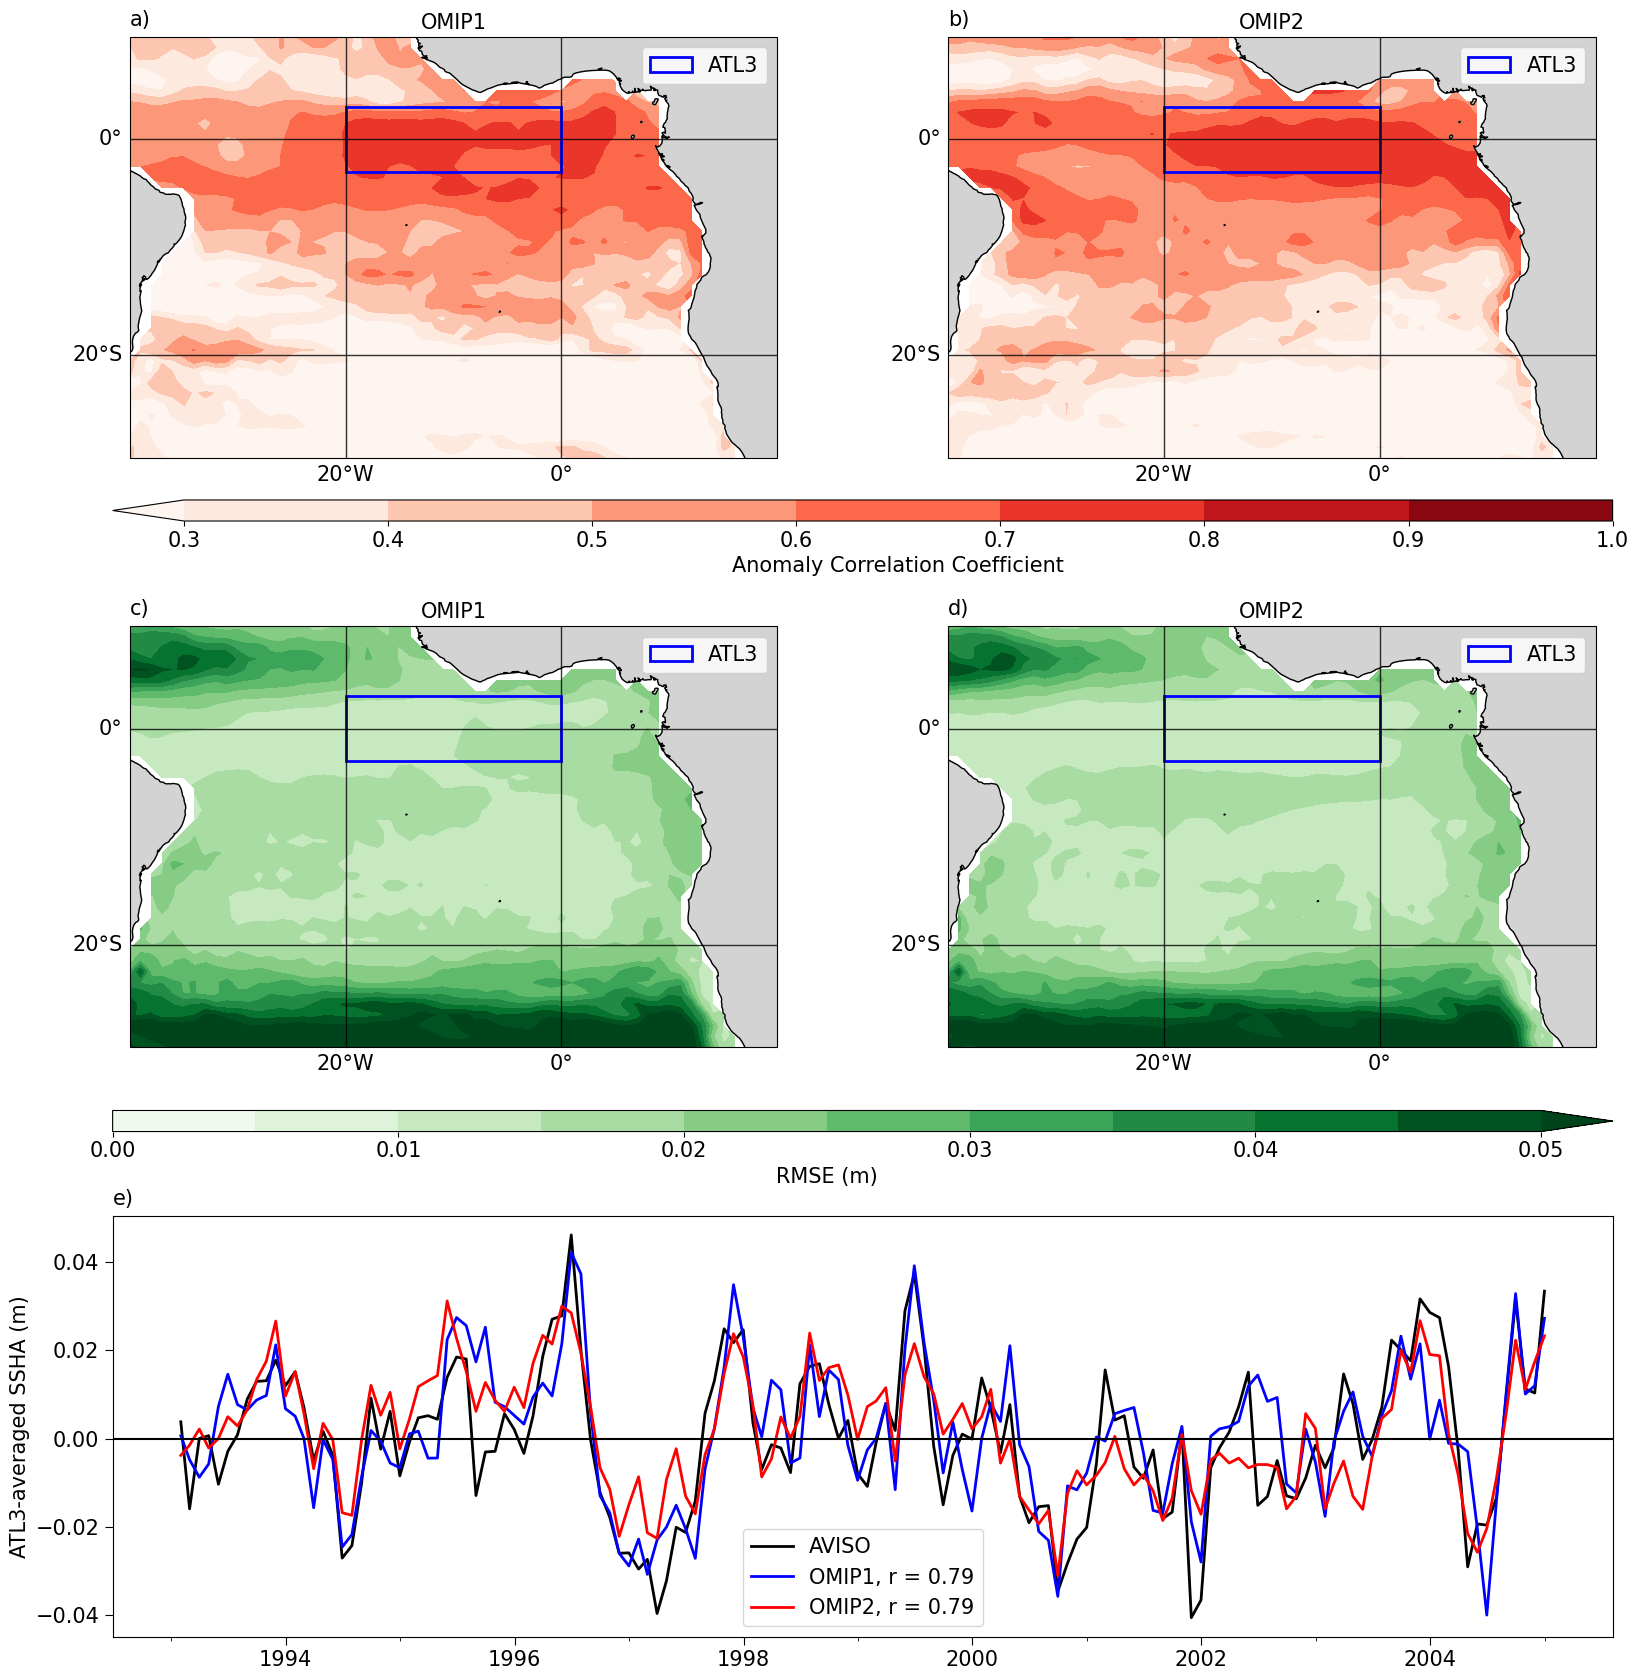

In [30]:
fig = plt.figure(figsize=[15,16])
fig.patch.set_facecolor('white')
ftz=15
gs=gridspec.GridSpec(3,2)
levels_acc = np.arange(0.3,1.1,0.1)
cmap=plt.cm.Reds
years = mdates.YearLocator()
cmap_rmse = plt.cm.Greens

levels_rmse = np.arange(0,0.055,0.005)
ax3 = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())

ax5 = fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree())
ax6 = fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree())

ax7 = fig.add_subplot(gs[2,:])
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.40, wspace=0.2)


cax0 = inset_axes(ax7,
                 width='100%',
                 height='5%',
                 loc='lower left',
                 bbox_to_anchor=(0,2.65,1,1),
                 bbox_transform = ax7.transAxes,
                 borderpad=0)


cax1 = inset_axes(ax7,
                 width='100%',
                 height='5%',
                 loc='lower left',
                 bbox_to_anchor=(0,1.2,1,1),
                 bbox_transform = ax7.transAxes,
                 borderpad=0)






p0=ax3.contourf(zosa_eq_omip1_atl_for_aviso.lon,
               zosa_eq_omip2_atl_for_aviso.lat,
               ACC_ssh_omip1_mean[:,:],levels=levels_acc,extend='min',cmap=plt.cm.Reds)
gl = ax3.gridlines(crs = ccrs.PlateCarree(),draw_labels=True,linewidth=1,color='black',alpha=0.8,linestyle='-')
gl.xlabels_top = False
gl.ylabels_right=False
gl.xlabel_style = {'size':ftz, 'color':'black'}
gl.ylabel_style = {'size':ftz, 'color':'black'}
gl.xlocator = mticker.FixedLocator([-40,-20,0])
gl.ylocator = mticker.FixedLocator([-20,0])
ax3.coastlines(linewidth=1,zorder=4)
ax3.add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=2)
ax3.add_patch(mpatches.Rectangle(xy=[-20,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='blue',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL3',transform=ccrs.PlateCarree()))

ax3.legend(fontsize=ftz)
ax3.set_title('OMIP1',fontsize=ftz)



p0=ax4.contourf(zosa_eq_omip2_atl_for_aviso.lon,
               zosa_eq_omip2_atl_for_aviso.lat,
               ACC_ssh_omip2_mean[:,:],levels=levels_acc,extend='min',cmap=plt.cm.Reds)
gl = ax4.gridlines(crs = ccrs.PlateCarree(),draw_labels=True,linewidth=1,color='black',alpha=0.8,linestyle='-')
gl.xlabels_top = False
gl.ylabels_right=False
gl.xlabel_style = {'size':ftz, 'color':'black'}
gl.ylabel_style = {'size':ftz, 'color':'black'}
gl.xlocator = mticker.FixedLocator([-40,-20,0])
gl.ylocator = mticker.FixedLocator([-20,0])
ax4.coastlines(linewidth=1,zorder=4)
ax4.add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=2)
ax4.add_patch(mpatches.Rectangle(xy=[-20,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='blue',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL3',transform=ccrs.PlateCarree()))
cbar = plt.colorbar(p0,cax0,orientation='horizontal')
cbar.ax.tick_params(labelsize=ftz)
cbar.set_label('Anomaly Correlation Coefficient',fontsize=ftz)
ax4.legend(fontsize=ftz)
ax4.set_title('OMIP2',fontsize=ftz)


p0=ax5.contourf(zosa_eq_omip1_atl_for_aviso.lon,
               zosa_eq_omip2_atl_for_aviso.lat,
               RMSE_ssh_omip1_mean[:,:],levels=levels_rmse,extend='max',cmap=cmap_rmse)
gl = ax5.gridlines(crs = ccrs.PlateCarree(),draw_labels=True,linewidth=1,color='black',alpha=0.8,linestyle='-')
gl.xlabels_top = False
gl.ylabels_right=False
gl.xlabel_style = {'size':ftz, 'color':'black'}
gl.ylabel_style = {'size':ftz, 'color':'black'}
gl.xlocator = mticker.FixedLocator([-40,-20,0])
gl.ylocator = mticker.FixedLocator([-20,0])
ax5.coastlines(linewidth=1,zorder=4)
ax5.add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=2)
ax5.add_patch(mpatches.Rectangle(xy=[-20,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='blue',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL3',transform=ccrs.PlateCarree()))

ax5.legend(fontsize=ftz)
ax5.set_title('OMIP1',fontsize=ftz)



p0=ax6.contourf(zosa_eq_omip2_atl_for_aviso.lon,
               zosa_eq_omip2_atl_for_aviso.lat,
               RMSE_ssh_omip2_mean[:,:],levels=levels_rmse,extend='max',cmap=cmap_rmse)
gl = ax6.gridlines(crs = ccrs.PlateCarree(),draw_labels=True,linewidth=1,color='black',alpha=0.8,linestyle='-')
gl.xlabels_top = False
gl.ylabels_right=False
gl.xlabel_style = {'size':ftz, 'color':'black'}
gl.ylabel_style = {'size':ftz, 'color':'black'}
gl.xlocator = mticker.FixedLocator([-40,-20,0])
gl.ylocator = mticker.FixedLocator([-20,0])
ax6.coastlines(linewidth=1,zorder=4)
ax6.add_feature(cartopy.feature.LAND,edgecolor='black',color='lightgrey',zorder=2)
ax6.add_patch(mpatches.Rectangle(xy=[-20,-3],
                                   width=20,
                                   height=6,
                                   edgecolor='blue',
                                   fill=None,
                                   alpha=1,linewidth=2,zorder=2,label='ATL3',transform=ccrs.PlateCarree()))
cbar = plt.colorbar(p0,cax1,orientation='horizontal')
cbar.ax.tick_params(labelsize=ftz)
cbar.set_label('RMSE (m)',fontsize=ftz)
ax6.legend(fontsize=ftz)
ax6.set_title('OMIP2',fontsize=ftz)


ax7.plot(zosa_eq_omip1_atl3_for_aviso.time,ssha_aviso_atl3_dtd,color='black',label='AVISO',linewidth=2)
ax7.plot(zosa_eq_omip1_atl3_for_aviso.time,
        zosa_eq_omip1_atl3_for_aviso.mean(dim='model'),color='blue',label='OMIP1, r = 0.79',linewidth=2)
ax7.plot(zosa_eq_omip1_atl3_for_aviso.time,
        zosa_eq_omip2_atl3_for_aviso.mean(dim='model'),color='red',label='OMIP2, r = 0.79',linewidth=2)
ax7.axhline(0,color='black')
#ax7.set_ylim([-2,2])
ax7.tick_params(labelsize=ftz)
ax7.set_ylabel('ATL3-averaged SSHA (m)',fontsize=ftz)
ax7.legend(fontsize=ftz)
ax7.xaxis.set_minor_locator(years)
ax7.tick_params(which='minor', length=3)
ax7.tick_params(which='major', length=6)


ax3.text(0,1.04,string.ascii_lowercase[0]+')',transform=ax3.transAxes,size=ftz,        
           verticalalignment='center') 
ax4.text(0,1.04,string.ascii_lowercase[1]+')',transform=ax4.transAxes,size=ftz,        
           verticalalignment='center') 
ax5.text(0,1.04,string.ascii_lowercase[2]+')',transform=ax5.transAxes,size=ftz,        
           verticalalignment='center') 
ax6.text(0,1.04,string.ascii_lowercase[3]+')',transform=ax6.transAxes,size=ftz,        
           verticalalignment='center') 
ax7.text(0,1.04,string.ascii_lowercase[4]+')',transform=ax7.transAxes,size=ftz,        
           verticalalignment='center') 

plt.savefig(path_fig+'figure_S04.png',bbox_inches='tight',dpi=300)